In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'colorful-fashion-dataset-for-object-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1942455%2F3200379%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240621%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240621T133353Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0bad4e8eb32d9c4d8b133ba994238c6948e5935ad06e2a9ac267e05e04141bc97cc20077d619f869b7d89308c7e98d526a12ca0c7a935ed6c362bd25ac1180179a7c2ce7ce623a6e091fec1c2918acb773172a6865ab8cfe6854227640d8e00d427a3f9671e74f5ed2b4e0de2dde257ec4f6981c23c2eec0ea160c608ae0a1578f7e2584b69a9b1fd96294e135bbf410c2b25f9c6c33a4119d0f4dbc03df237dcf7807157da3a0874cb0e4bd7ef4daade9fd8daa82ea4f14376f677146442aae3804ee6c1fbbd2e3a972775e91dae62360eaf4d59b046aee35cfc1ecd1b3c4da8c40ea3c17a319d581436155cda3f03e083852053b1a175745a2f5fbb871b858'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 109441424 bytes downloaded
Downloaded and uncompressed: colorful-fashion-dataset-for-object-detection
Data source import complete.


## Install ultralytics

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 8.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
# Check GPU is working or not
import torch
print(f"Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Using torch 2.3.0+cu121 (Tesla T4)


In [4]:
images_path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/'
annotations_path  = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/Annotations_txt/'
path = '/kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/'

# Try YOLOv8

In [5]:
from ultralytics import YOLO

# load pre-trained model
model = YOLO("yolov8m.pt")

100%|██████████| 49.7M/49.7M [00:00<00:00, 150MB/s]


# Plot Training Data with Annotations

In [8]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])

            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

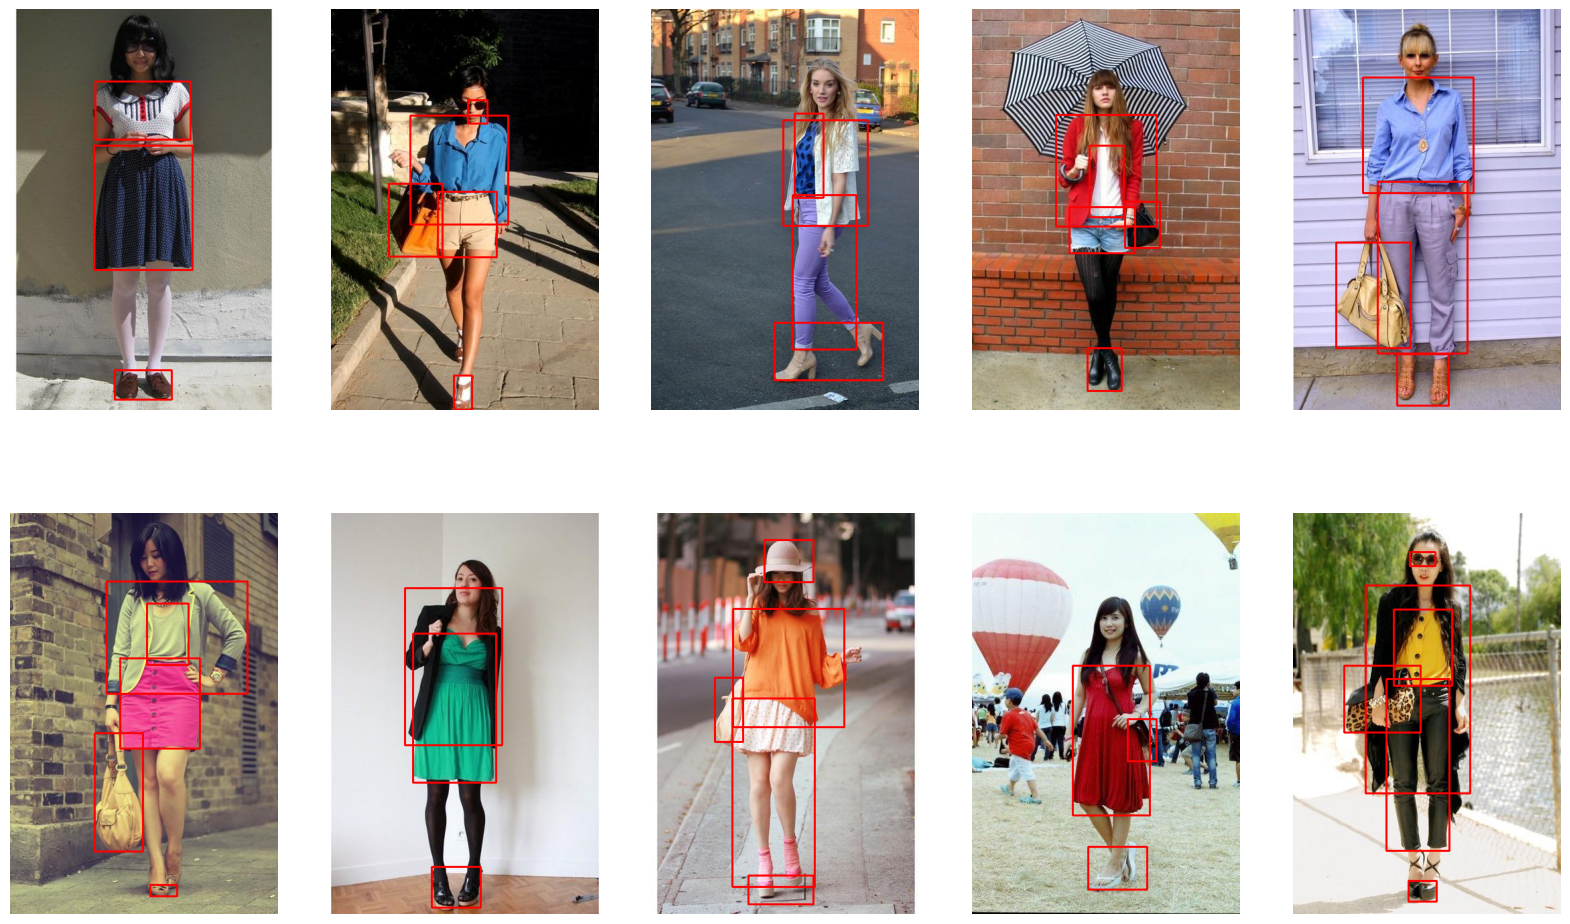

In [10]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(20,12))
ls = os.listdir(images_path)
c=1
for i in random.sample(ls, 10):
    img = plt.imread(images_path+i)
    i = i.rstrip('.jpg') + '.txt'
    plt.subplot(2,5, c)
    plot_annotations(img, i)
    c+=1

# Prepare Dataset

In [11]:
train = []
with open(path+'ImageSets/Main/trainval.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        train.append(line)

test = []
with open(path+'ImageSets/Main/test.txt', 'r') as f:
    for line in f.readlines():
        if line[-1]=='\n':
            line = line[:-1]
        test.append(line)

In [12]:
len(train), len(test)

(2145, 537)

In [13]:
os.mkdir('train')
os.mkdir('train/images')
os.mkdir('train/labels')

os.mkdir('test')
os.mkdir('test/images')
os.mkdir('test/labels')

In [14]:
import tqdm
import shutil
train_path = '/content/train/'
test_path = '/content/test/'

print('Copying Train Data..!!')
for i in tqdm.tqdm(train):
    a = shutil.copyfile(images_path+i+'.jpg', train_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', train_path+'labels/'+i+'.txt')

print('Copying Test Data..!!')
for i in tqdm.tqdm(test):
    a = shutil.copyfile(images_path+i+'.jpg', test_path+'images/'+i+'.jpg')
    a = shutil.copyfile(annotations_path+i+'.txt', test_path+'labels/'+i+'.txt')

Copying Train Data..!!


100%|██████████| 2145/2145 [00:03<00:00, 652.83it/s] 


Copying Test Data..!!


100%|██████████| 537/537 [00:00<00:00, 1929.75it/s]


# Train Custom Model

In [15]:
text = """
train: /content/train
val: /content/test

# number of classes
nc: 10

# class names
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
"""
with open("data.yaml", 'w') as file:
    file.write(text)

In [16]:
model = YOLO("yolov8m.pt")

model.train(data='/content/data.yaml', epochs=5)

Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 22.2MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.23M/6.23M [00:00<00:00, 100MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/train/labels... 2145 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2145/2145 [00:01<00:00, 2046.86it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/test/labels... 537 images, 0 backgrounds, 0 corrupt: 100%|██████████| 537/537 [00:00<00:00, 938.39it/s]


val: New cache created: /content/test/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      7.23G      1.314      1.835      1.418         10        640: 100%|██████████| 135/135 [01:20<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  2.09it/s]

                   all        537       2035      0.562      0.654       0.63      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5       7.2G      1.254      1.227      1.372          4        640: 100%|██████████| 135/135 [01:22<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.73it/s]

                   all        537       2035      0.585      0.648      0.635      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.19G      1.213      1.126      1.344          9        640: 100%|██████████| 135/135 [01:14<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]

                   all        537       2035      0.659      0.719      0.725      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.09G      1.181       1.03      1.325          9        640: 100%|██████████| 135/135 [01:14<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.17it/s]

                   all        537       2035      0.724      0.761      0.771      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.17G      1.114     0.9133      1.282          7        640: 100%|██████████| 135/135 [01:16<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.64it/s]

                   all        537       2035       0.76      0.763       0.78      0.529



5 epochs completed in 0.126 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25845550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:10<00:00,  1.67it/s]


                   all        537       2035      0.761      0.763       0.78       0.53
              sunglass         82         82      0.753      0.134      0.317      0.112
                   hat         77         77      0.787      0.817      0.835      0.486
                jacket        179        181      0.845      0.757      0.864      0.656
                 shirt        361        366      0.743      0.863      0.822      0.594
                 pants        114        114      0.823       0.93      0.957       0.76
                shorts        107        107      0.756      0.916      0.781      0.524
                 skirt        186        186      0.751      0.828      0.824      0.654
                 dress        128        128      0.692      0.828      0.803      0.605
                   bag        274        274      0.731      0.737      0.789      0.444
                  shoe        520        520      0.734      0.822      0.808      0.462
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ae0c5fc16c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

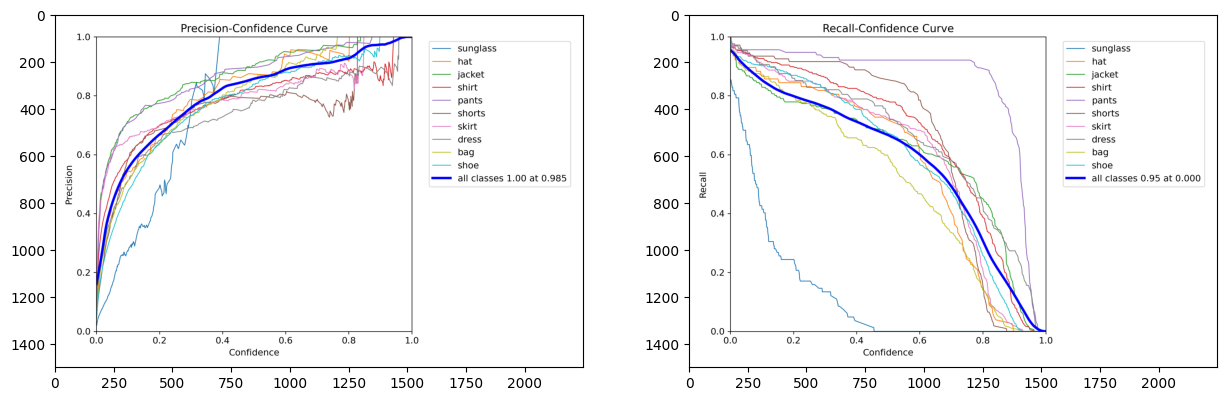

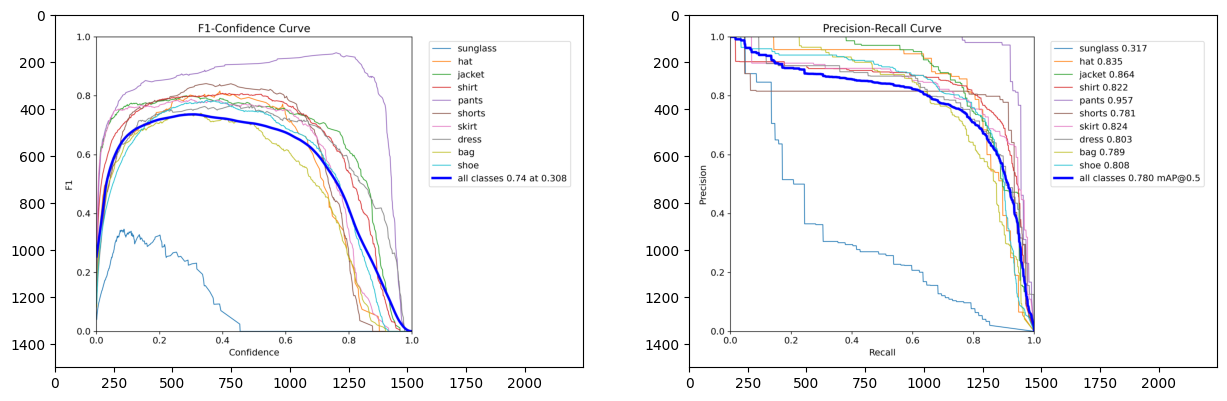

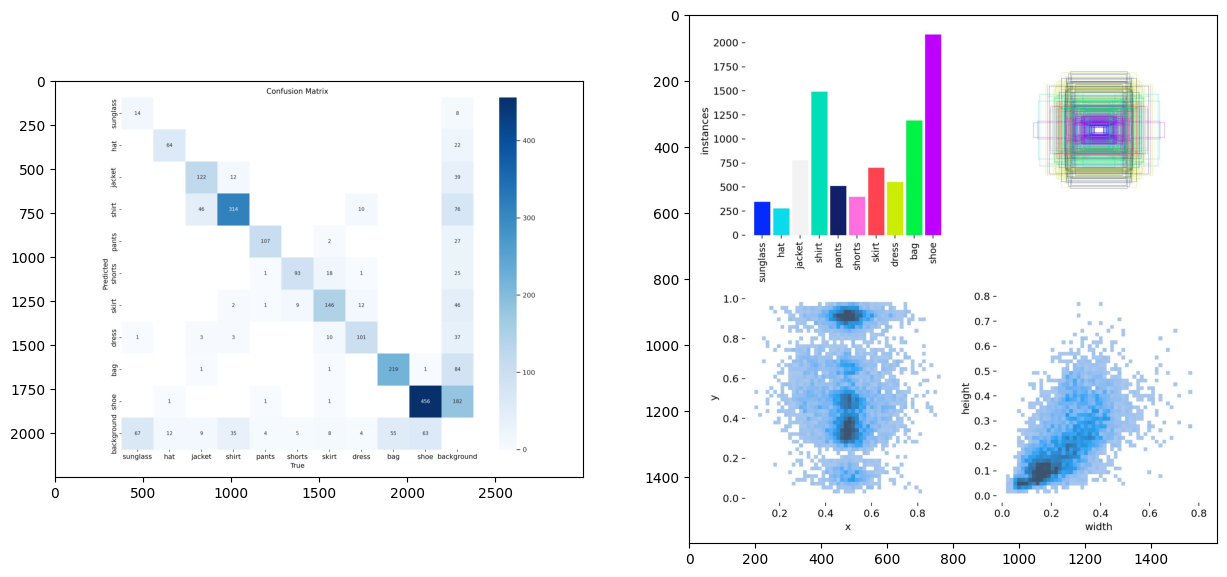

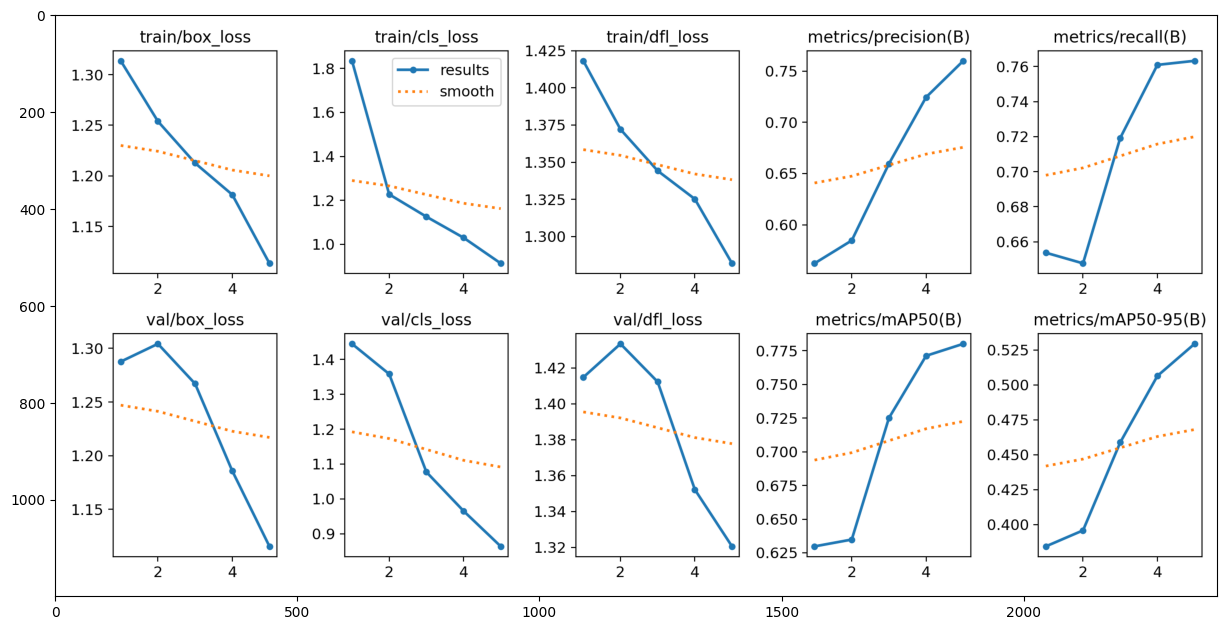

In [17]:
%matplotlib inline
model_path = '/content/runs/detect/train/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))

# Test Model

In [19]:
# choose random image from dataset
plt.figure(figsize=(20,20))
imgs = random.sample(os.listdir(images_path), 6)
c=1
for img in imgs:
    i=model.predict(source=images_path+img, conf=0.4, save=True, line_thickness=2)

    im = plt.imread('/content/runs/detect/predict2/'+img)
    plt.subplot(2,3,c)
    plt.axis('off')
    plt.imshow(im)
    c+=1

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.399999999999999' in the future. Please use 'line_width' instead.

image 1/1 /kaggle/input/colorful-fashion-dataset-for-object-detection/colorful_fashion_dataset_for_object_detection/JPEGImages/89736.jpg: 640x448 1 dress, 1 bag, 27.4ms
Speed: 2.8ms preprocess, 27.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs/detect/train3


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect/predict2/89736.jpg'

<Figure size 2000x2000 with 0 Axes>

In [21]:
model.export(format='onnx')

Ultralytics YOLOv8.2.38 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (49.6 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 80.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 10.5s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success ✅ 17.1s, saved as 'runs/detect/train/weights/best.onnx' (98.8 MB)

Export complete (20.2s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.onnx imgsz=640 data=/content/data.yaml  
Visualize:    

'runs/detect/train/weights/best.onnx'